In [ ]:
!pip install --upgrade tensorflow

In [2]:
!pip install --upgrade scikit-learn

^C


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
import sys
assert sys.version_info >= (3, 5)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow_hub as hub
assert tf.__version__ >= "2.0"

import sklearn
assert sklearn.__version__ >= "0.20"

try:
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.test.is_gpu_available():
    print("No GPU was detected. This code can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

import time
import pandas as pd
import numpy as np
import os

np.random.seed(20)
tf.random.set_seed(20)

PROJECT_ROOT_DIR = "."
FOLDER= "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. This code can be very slow without a GPU.


In [6]:
tf.__version__

'2.3.0'

In [7]:
import tensorflow as tf
tf.test.is_gpu_available()

False

In [38]:
!pip install spacy
!python -m spacy download en

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\satya\anaconda3\envs\tenserflow\lib\site-packages\en_core_web_sm -->
C:\Users\satya\anaconda3\envs\tenserflow\lib\site-packages\spacy\data\en

You do not have sufficient privilege to perform this operation.



[!] Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import itertools
import re
import spacy

In [11]:
trainfile = "./data/training.1600000.processed.noemoticon.csv"
columns = ['polarity','id','date','query_string','twitter_user','tweet']

In [12]:
# Import Train data set
df_train = pd.read_csv(trainfile,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')
df_train.shape

(1600000, 6)

###Data Preprocessing

In [13]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   polarity      1600000 non-null  int64 
 1   id            1600000 non-null  int64 
 2   date          1600000 non-null  object
 3   query_string  1600000 non-null  object
 4   twitter_user  1600000 non-null  object
 5   tweet         1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [14]:
df_train.tweet[0:10]


0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @Kwesidei not the whole crew 
6                                          Need a hug 
7    @LOLTrish hey  long time no see! Yes.. Rains a...
8                 @Tatiana_K nope they didn't have it 
9                            @twittera que me muera ? 
Name: tweet, dtype: object

Matplotlib is building the font cache; this may take a moment.


array([[<AxesSubplot:title={'center':'polarity'}>]], dtype=object)

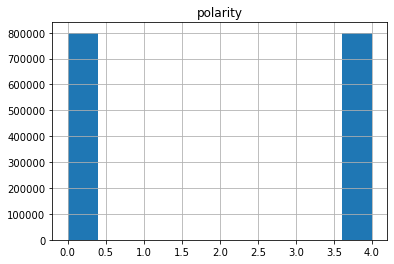

In [16]:
df_train.hist(["polarity"])

###Split Train and Test dataset

In [17]:
NUMTRAIN = 150000
NUMTEST = 3000
train_set = df_train[['id','polarity', 'tweet']].sample(NUMTRAIN)
test_set = df_train[['id','polarity', 'tweet']].sample(NUMTEST)

In [18]:
X_train = train_set.drop("polarity", axis=1) # drop labels for training set
y_train = train_set["polarity"].copy()

In [19]:
X_test = test_set.drop("polarity", axis=1) # drop labels for test set
y_test = test_set["polarity"].copy()

In [20]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("y_train: "+ str(y_train.shape)+ str(type(y_train)))
print("X_test: " + str(X_test.shape) + str(type(X_test)))
print("y_test: "+ str(y_test.shape)+ str(type(y_test)))

X_train: (150000, 2)<class 'pandas.core.frame.DataFrame'>
y_train: (150000,)<class 'pandas.core.series.Series'>
X_test: (3000, 2)<class 'pandas.core.frame.DataFrame'>
y_test: (3000,)<class 'pandas.core.series.Series'>


In [21]:
y_train.head()

313228     0
253601     0
1041037    4
217422     0
495067     0
Name: polarity, dtype: int64


###Functions : Text-preprocessing and Lemmatize (Normalize) Tweets

In [22]:
def text_processing(tweet):
    # remove https links
    clean_tweet = re.sub(r'http\S+', '', tweet)
    # remove punctuation marks
    punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
    clean_tweet = ''.join(ch for ch in clean_tweet if ch not in set(punctuation))
    # convert text to lowercase
    clean_tweet = clean_tweet.lower()
    # remove numbers
    clean_tweet = re.sub('\d', ' ', clean_tweet)
    # remove whitespaces
    clean_tweet = ' '.join(clean_tweet.split())
    return clean_tweet

In [31]:
!python -m spacy download en

  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.3.1-py3-none-any.whl size=782936124 sha256=9b5fa6bdba6dc0327a17ad61dcad00ad4efc1b14776bf2b5ac876f75541163b8
  Stored in directory: C:\Users\satya\AppData\Local\Temp\pip-ephem-wheel-cache-hay_iuve\wheels\8b\bb\bb\bdc918f4b37d930a1be9ed876e7b2c2ee518a34803d78a248e
Successfully built en-core-web-lg
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\satya\anaconda3\envs\tenserflow\lib\site-packages\en_core_web_lg -->
C:\Users\satya\anaconda3\envs\tenserflow\lib\site-packages\spacy\data\en


You do not have sufficient privilege to perform this operation.
Traceback (most recent call last):
  File "C:\Users\satya\anaconda3\envs\tenserflow\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\satya\anaconda3\envs\tenserflow\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\satya\anaconda3\envs\tenserflow\lib\site-packages\spacy\__main__.py", line 33, in <module>
    plac.call(commands[command], sys.argv[1:])
  File "C:\Users\satya\anaconda3\envs\tenserflow\lib\site-packages\plac_core.py", line 348, in call
    cmd, result = parser.consume(arglist)
  File "C:\Users\satya\anaconda3\envs\tenserflow\lib\site-packages\plac_core.py", line 217, in consume
    return cmd, self.func(*(args + varargs + extraopts), **kwargs)
  File "C:\Users\satya\anaconda3\envs\tenserflow\lib\site-packages\spacy\cli\link.py", line 64, in link
    symlink_to(link_path, model_path)
  File "C:\Users\satya\anaconda3\e

In [39]:
# import the english language model from spacy'
#nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en', disable=['parser', 'ner'])
#nlp = spacy.load('en')

# function to lemmatize text
def lemmatization(tweets):
    lemma_tweet = []
    for i in tweets:
        t = [token.lemma_ for token in nlp(i)]
        lemma_tweet.append(' '.join(t))
    return lemma_tweet

In [40]:
X_train['clean_tweet'] = X_train['tweet'].apply(lambda x: text_processing(x))
X_test['clean_tweet'] = X_test['tweet'].apply(lambda x: text_processing(x))

In [41]:
X_train.head()

,id,tweet,clean_tweet
313228,2001705696,@yaeljk get to a show girl! Do whatcha gotta d...,yaeljk get to a show girl do whatcha gotta do ...
253601,1984029518,Ex boyfriends suck -pete! the alien-,ex boyfriends suck pete the alien
1041037,1957027349,.@SpacieStaycie which one did you like best?,.spaciestaycie which one did you like best
217422,1975936563,damn my back is hella hurtting at work,damn my back is hella hurtting at work
495067,2185120448,@tristanwilds unfortunately my days already over,tristanwilds unfortunately my days already over


In [42]:
%%time
X_train["clean_tweet"] = lemmatization(X_train["clean_tweet"])
X_test['clean_tweet'] = lemmatization(X_test['clean_tweet'])

Wall time: 12min 9s


In [43]:
X_train.head()

,id,tweet,clean_tweet
313228,2001705696,@yaeljk get to a show girl! Do whatcha gotta d...,yaeljk get to a show girl do whatcha got to do...
253601,1984029518,Ex boyfriends suck -pete! the alien-,ex boyfriend suck pete the alien
1041037,1957027349,.@SpacieStaycie which one did you like best?,.spaciestaycie which one do -PRON- like good
217422,1975936563,damn my back is hella hurtting at work,damn -PRON- back be hella hurtte at work
495067,2185120448,@tristanwilds unfortunately my days already over,tristanwild unfortunately -PRON- day already over


In [44]:
X_test.head()

,id,tweet,clean_tweet
1496875,2070227533,Working at the Devon Theater on the production...,work at the devon theater on the production of...
732398,2264061329,"@thetoniomethod Bro, the link doesn't work....","thetoniomethod bro , the link do not work ...."
601669,2221199219,Just heard a bad news that there's a 99% chanc...,just hear a bad news that there be a chance th...
896297,1692990666,"@jason_mraz JASON, FREAKIN AMAZING PERFORMANC...","jasonmraz jason , freakin amazing performance ..."
652957,2238425040,.......pride overshadowed by extreme fatigue.,....... pride overshadow by extreme fatigue .


In [47]:
PATH="./data/"
X_train_lemma_file =  PATH + "X_train_lemma150k.csv"
X_test_lemma_file =   PATH + "X_test_lemma3k.csv"
y_train_lemma_file =  PATH + "y_train_lemma150k.csv"
y_test_lemma_file =   PATH + "y_test_lemma3k.csv"

In [48]:
X_train.to_csv(X_train_lemma_file, index=False)
X_test.to_csv(X_test_lemma_file, index=False)
y_train.to_csv(y_train_lemma_file, index=False, header=False)
y_test.to_csv(y_test_lemma_file, index=False, header=False)

In [49]:
X_train = pd.read_csv(X_train_lemma_file)
X_test = pd.read_csv(X_test_lemma_file)
y_train = pd.read_csv(y_train_lemma_file, squeeze=True, header=None)
y_test = pd.read_csv(y_test_lemma_file, squeeze=True, header=None)

In [50]:
X_train.head()

,id,tweet,clean_tweet
0,2001705696,@yaeljk get to a show girl! Do whatcha gotta d...,yaeljk get to a show girl do whatcha got to do...
1,1984029518,Ex boyfriends suck -pete! the alien-,ex boyfriend suck pete the alien
2,1957027349,.@SpacieStaycie which one did you like best?,.spaciestaycie which one do -PRON- like good
3,1975936563,damn my back is hella hurtting at work,damn -PRON- back be hella hurtte at work
4,2185120448,@tristanwilds unfortunately my days already over,tristanwild unfortunately -PRON- day already over


In [51]:
X_test.head()

,id,tweet,clean_tweet
0,2070227533,Working at the Devon Theater on the production...,work at the devon theater on the production of...
1,2264061329,"@thetoniomethod Bro, the link doesn't work....","thetoniomethod bro , the link do not work ...."
2,2221199219,Just heard a bad news that there's a 99% chanc...,just hear a bad news that there be a chance th...
3,1692990666,"@jason_mraz JASON, FREAKIN AMAZING PERFORMANC...","jasonmraz jason , freakin amazing performance ..."
4,2238425040,.......pride overshadowed by extreme fatigue.,....... pride overshadow by extreme fatigue .


In [52]:
y_train.head

<bound method NDFrame.head of 0         0
1         0
2         4
3         0
4         0
         ..
149995    4
149996    4
149997    0
149998    0
149999    4
Name: 0, Length: 150000, dtype: int64>

In [53]:
y_test.head

<bound method NDFrame.head of 0       4
1       0
2       0
3       4
4       0
       ..
2995    4
2996    0
2997    4
2998    4
2999    4
Name: 0, Length: 3000, dtype: int64>

In [54]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("y_train: "+ str(y_train.shape)+ str(type(y_train)))
print("X_test: " + str(X_test.shape) + str(type(X_test)))
print("y_test: "+ str(y_test.shape)+ str(type(y_test)))

X_train: (150000, 3)<class 'pandas.core.frame.DataFrame'>
y_train: (150000,)<class 'pandas.core.series.Series'>
X_test: (3000, 3)<class 'pandas.core.frame.DataFrame'>
y_test: (3000,)<class 'pandas.core.series.Series'>


In [55]:
X_train = X_train["clean_tweet"].values
X_test = X_test["clean_tweet"].values

In [56]:
print(X_train[0:5])

['yaeljk get to a show girl do whatcha got to do what if this be -PRON- last tour omg i do not wanna think about -PRON-'
 'ex boyfriend suck pete the alien'
 '.spaciestaycie which one do -PRON- like good'
 'damn -PRON- back be hella hurtte at work'
 'tristanwild unfortunately -PRON- day already over']


###Label Encoding

In [57]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)                     
y_train[:5]

array([0, 0, 1, 0, 0], dtype=int64)

In [58]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [59]:
y_train[0:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [60]:
X_train.shape # Should be (nb_of_records, )

(150000,)

In [61]:
y_test.shape # Sould be (nb_of_records, number_of_categories)

(3000, 2)

###Create Model using tf.hub: nnlm-en-dim128


In [62]:
MODEL = "nnlm-en-dim128"
VERSION = 2
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)

https://tfhub.dev/google/nnlm-en-dim128/2


In [63]:
hub_layer1 = hub.KerasLayer(URL, output_shape=[128], 
                           input_shape=[], 
                           dtype=tf.string
                          )
model = keras.Sequential()
model.add(hub_layer1)
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 124,659,458
Trainable params: 16,770
Non-trainable params: 124,642,688
_

In [64]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [91]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


###Execute Model

In [71]:
%%time
hist = model.fit(X_train, 
                 y_train, 
                 epochs=40,
                 batch_size=128, 
                 validation_split=0.2,
                 verbose = 1)
# Benchmark time: 6 min per 25 epochs for 80 000 records/batch 32
# Benchmark time: 2 min per 30 epochs for 80 000 records/64 nodes/batch 64
# Benchmark time: 2.5  min per 30 epochs for 150 000 records/128 nodes/batch 128

Epoch 1/40
938/938 [==============================] - 5s 6ms/step - loss: 0.5629 - accuracy: 0.7111 - val_loss: 0.5368 - val_accuracy: 0.7334
Epoch 2/40
938/938 [==============================] - 6s 7ms/step - loss: 0.5374 - accuracy: 0.7302 - val_loss: 0.5260 - val_accuracy: 0.7402
Epoch 3/40
938/938 [==============================] - 4s 5ms/step - loss: 0.5308 - accuracy: 0.7339 - val_loss: 0.5219 - val_accuracy: 0.7419
Epoch 4/40
938/938 [==============================] - 4s 5ms/step - loss: 0.5263 - accuracy: 0.7374 - val_loss: 0.5179 - val_accuracy: 0.7465
Epoch 5/40
938/938 [==============================] - 6s 6ms/step - loss: 0.5225 - accuracy: 0.7416 - val_loss: 0.5165 - val_accuracy: 0.7463
Epoch 6/40
938/938 [==============================] - 6s 7ms/step - loss: 0.5198 - accuracy: 0.7423 - val_loss: 0.5138 - val_accuracy: 0.7480
Epoch 7/40
938/938 [==============================] - 5s 5ms/step - loss: 0.5167 - accuracy: 0.7452 - val_loss: 0.5120 - val_accuracy: 0.7507
Epoch 

<function matplotlib.pyplot.show(close=None, block=None)>

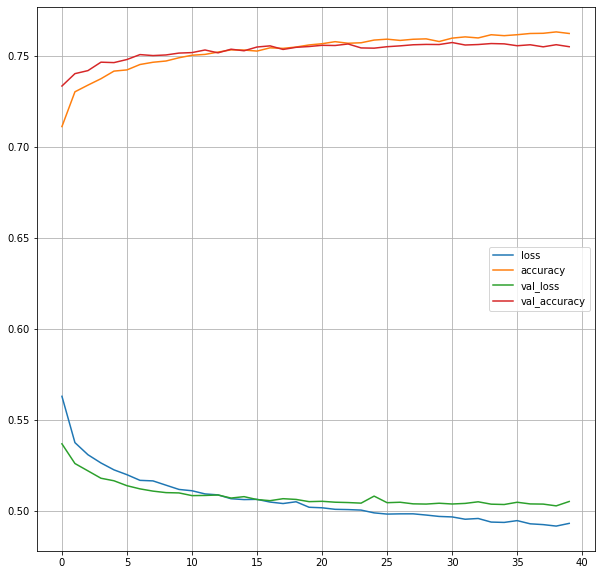

In [73]:
import matplotlib.pyplot as plt
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

###Evaluate Model

In [74]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

94/94 - 0s - loss: 0.5054 - accuracy: 0.7543
[0.5053826570510864, 0.7543333172798157]


In [75]:
print(X_train[0:10])

['yaeljk get to a show girl do whatcha got to do what if this be -PRON- last tour omg i do not wanna think about -PRON-'
 'ex boyfriend suck pete the alien'
 '.spaciestaycie which one do -PRON- like good'
 'damn -PRON- back be hella hurtte at work'
 'tristanwild unfortunately -PRON- day already over'
 'nickrich i do leave , but i have to come back . n wat u tryin to say u want -PRON- to go away'
 'misspipedream oh i feel very honoured lol . i know . -PRON- be read as i type . almost finish though'
 'earn -PRON- cpr amp first aid certification'
 'yay , people be follow -PRON- exciting'
 'pworld i can not drink wine for a couple more day . -PRON- be on an antibiotic -PRON- be go to smh at someone now because of -PRON- lol']


###Confusion Matrix

In [76]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False,
                          title='CM', 
                          cmap=plt.cm.Greens):
# This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix") # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout() 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label')

In [77]:
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [78]:
y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [79]:
cmResults = confusion_matrix(y_train_rounded, y_pred_rounded) 
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

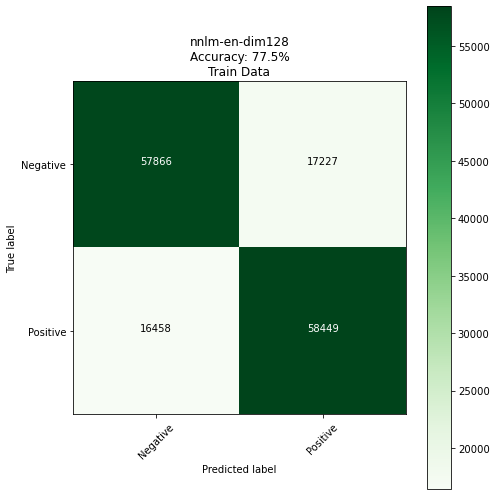

In [80]:
# Plot non-normalized confusion matrix 
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Train Data");

In [81]:
y_pred = model.predict(X_test)
y_pred_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test_rounded, y_pred_rounded)
accuracy = accuracy_score(y_test_rounded, y_pred_rounded)

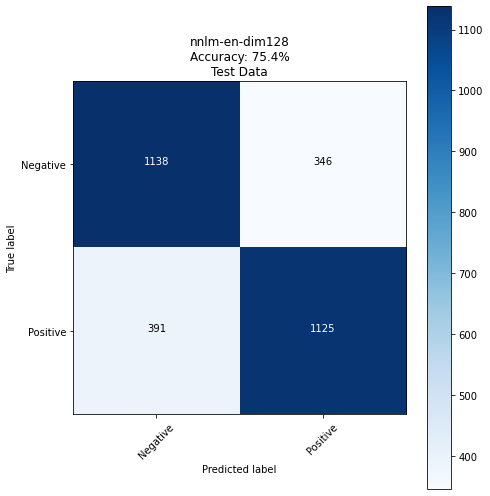

In [82]:
# Plot non-normalized confusion matrix 
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Test Data",
                      cmap=plt.cm.Blues);

###Test the Model with some sentences

In [83]:
# Create input tweets for testing the sentiment model 
tweets = {'tweet':['I do not dislike cabin cruisers',
                   'Montreal is a nice city in the summer!!!',
                    'I have a good feeling about this team#11212',
                    'The Montreal hockey team will be making the playoffs',
                    'The weather in Montreal is very nice in the summer',
                    'Coronet has the best lines of all day cruisers',
                    'The show was not funny...',
                    'The dog is angry',
                    'The food at the restaurant could be better',
                    'The flight is a long one',
                    'It would be nice if the weather was better in Montreal *&&%&*&##!1',
                    'I dislike old cabin cruisers',
                   ],
          'sentiments':[4, 
                        4,
                       4,
                       4,
                       4,
                       4,
                       0,
                       0,
                       0,
                       0,
                       0,
                       0
                      ]
         } 
  
# Create DataFrame 
df_test = pd.DataFrame(tweets)

In [84]:
df_test['clean_tweet'] = df_test['tweet'].apply(lambda x: text_processing(x))

In [85]:
df_test["clean_tweet"] = lemmatization(df_test["clean_tweet"])

In [86]:
df_test

,tweet,sentiments,clean_tweet
0,I do not dislike cabin cruisers,4,i do not dislike cabin cruiser
1,Montreal is a nice city in the summer!!!,4,montreal be a nice city in the summer
2,I have a good feeling about this team#11212,4,i have a good feeling about this team
3,The Montreal hockey team will be making the pl...,4,the montreal hockey team will be make the playoff
4,The weather in Montreal is very nice in the su...,4,the weather in montreal be very nice in the su...
5,Coronet has the best lines of all day cruisers,4,coronet have the good line of all day cruiser
6,The show was not funny...,0,the show be not funny ...
7,The dog is angry,0,the dog be angry
8,The food at the restaurant could be better,0,the food at the restaurant could be well
9,The flight is a long one,0,the flight be a long one


In [87]:
sentiments = df_test["sentiments"].copy()
label_encoder = LabelEncoder()
sentiments = label_encoder.fit_transform(sentiments)
sentiments = keras.utils.to_categorical(sentiments)

In [88]:
X_input = df_test["clean_tweet"].values

In [89]:
print(model.predict(X_input).round(0))

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [90]:
print(sentiments)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
